# Discrete Time Model for Burgers' PDE

In [14]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import loadmat
import tensorflow_probability as tfp
from time import time
print ( "Libraries imported" )

Libraries imported


##### Please check the path of the burgers_shock.mat file and the IRK weights directory before executing.

Here, we take q = 64 due to computation constraints. Ideally q = 500.

In [15]:
burgers_shock_path = "/kaggle/input/burgers-shock/burgers_shock.mat"
IRK_weights_path = "/kaggle/input/irk-weights/IRK_weights"

c = tf.constant ( 0.01 / np.pi, dtype = tf.float32 )

t_start = 0.1
t_end = 0.9

q = 64
N_x = 250

adam_epochs = 0
lbfgs_epochs = 50000

print ( burgers_shock_path, "\n" + IRK_weights_path )

/kaggle/input/burgers-shock/burgers_shock.mat 
/kaggle/input/irk-weights/IRK_weights


In [16]:
data = loadmat ( burgers_shock_path )
    
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
u = np.real ( data['usol'] ).T

t_start_index = int(t_start * 100)
t_end_index = int(t_end * 100)

dt = t[t_end_index] - t[t_start_index]

print ( t.shape, x.shape, u.shape, dt )


(100, 1) (256, 1) (100, 256) [0.8]


In [17]:
x_index = np.random.choice ( u.shape[1], N_x, replace = False ) 
x0 = x[x_index,:]
u0 = u[t_start_index:t_start_index + 1, x_index].T

x1 = np.array ( [ [ 1.0 ], [ -1.0 ] ] )

x0_tf = tf.convert_to_tensor ( x0, dtype = tf.float32 )
u0_tf = tf.convert_to_tensor ( u0, dtype = tf.float32 )
x1_tf = tf.convert_to_tensor ( x1, dtype = tf.float32 )

print ( x0.shape, u0.shape )
print ( x1 )

(250, 1) (250, 1)
[[ 1.]
 [-1.]]


Raissi et al. (2019), uses this segment of code for loading the IRK coefficients.

In [18]:
tmp = np.float32 ( np.loadtxt ( f"{IRK_weights_path}/Butcher_IRK%d.txt" % (q), ndmin = 2 ) )
IRK_weights = np.reshape(tmp[0:q**2+q], (q+1,q))
IRK_times = tmp[q**2+q:]

dt = tf.convert_to_tensor ( dt, dtype = tf.float32 )

print ( IRK_weights.shape, IRK_times.shape )

(65, 64) (64, 1)


In [19]:
model = tf.keras.Sequential ( [
        tf.keras.layers.InputLayer ( input_shape = ( 1, ) ),
        tf.keras.layers.Dense ( 50, activation = 'tanh' ),
        tf.keras.layers.Dense ( 50, activation = 'tanh' ),
        tf.keras.layers.Dense ( 50, activation = 'tanh' ),
        tf.keras.layers.Dense ( 50, activation = 'tanh' ),
        tf.keras.layers.Dense ( q + 1 )
    ] )

print ( model.summary() )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 65)             │         3,315 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,065 (43.22 KB)

 Trainable params: 11,065 (43.22 KB)

 Non-trainable params: 0 (0.00 B)

None


#### These are our loss functions.

In [20]:
@tf.function
def SSE_n():
    
    with tf.GradientTape ( persistent = True ) as tape2:
        tape2.watch ( x0_tf )
        with tf.GradientTape() as tape1:
            tape1.watch ( x0_tf )
            u1_pred = model ( x0_tf )
            u_pred = u1_pred[:, :-1]
        
        du_dx = tape1.batch_jacobian ( u_pred, x0_tf )
        du_dx = tf.squeeze ( du_dx, axis = -1 )
        
    d2u_dx2 = tape2.batch_jacobian ( du_dx, x0_tf )
    d2u_dx2 = tf.squeeze ( d2u_dx2, axis = -1 )
    
    del tape2
    
    F = -u_pred * du_dx + c * d2u_dx2
    final_pred = u1_pred - dt * tf.matmul ( F, IRK_weights.T ) 
    
    return tf.reduce_sum ( tf.square ( final_pred - u0_tf ) )

@tf.function
def SSE_b():
    return tf.reduce_sum ( tf.square ( model ( x1_tf ) ) )

In [21]:

# Functions for lbfgs 

# Flatten our model weights into a single vector

func_call = 1
start = time()

def pack_weights ( vars ):
    return tf.concat ( [ tf.reshape ( v, [-1] ) for v in vars ], axis = 0 )

# Unflatten weights

def unpack_weights ( vars, flat ):
    idx = 0
    for v in vars:
        size = tf.size ( v )
        shape = v.shape
        v.assign ( tf.reshape ( flat[idx:idx+size], shape ) )
        idx += size

# passing gradients for lbfgs 

def value_and_gradients ( flat_weights ):
    global func_call, start
    
    unpack_weights ( model.trainable_variables, flat_weights )

    with tf.GradientTape() as tape:
        loss_n = SSE_n()
        loss_b = SSE_b()
        loss = loss_n + loss_b

    if ( func_call % 1000 == 0 ):
        print ( "INFO: LBFGS Call {} reached, SSE_n : {}, SSE_b: {}, Time: {}".format ( str ( func_call ), str ( float ( loss_n ) ), str ( float ( loss_b ) ), str ( float ( time() - start ) ) ) )
        model.save_weights ( "burger_latest.weights.h5" )
    func_call += 1

    grads = tape.gradient ( loss, model.trainable_variables )
    return loss, pack_weights ( grads )


Training.

In [22]:
# Training with adam

print ( "INFO: Training Started" )

opt = tf.keras.optimizers.Adam ( learning_rate = 0.001 )

for epoch in range ( 1, adam_epochs + 1 ):
    with tf.GradientTape() as tape:
        loss_n = SSE_n()
        loss_b = SSE_b()
        loss = loss_n + loss_b
    grads = tape.gradient ( loss, model.trainable_variables )
    opt.apply_gradients ( zip ( grads, model.trainable_variables ) )
    
    if ( epoch % 1000 == 0 ):
        print ( "INFO: Adam Epoch {} reached, SSE_n : {}, SSE_b: {}, Time: {}".format ( str ( epoch ), str ( float ( loss_n ) ), str ( float ( loss_b ) ), str ( float ( time() - start ) ) ) )
        model.save_weights ( "burger_latest.weights.h5" )

print ( "INFO: Training with Adam done" )


INFO: Training Started
INFO: Training with Adam done


In [23]:

lbfgs_train = tfp.optimizer.lbfgs_minimize (
    value_and_gradients,
    initial_position = pack_weights ( model.trainable_variables ),
    max_iterations = lbfgs_epochs,
    tolerance = 1e-8
)

print ( "INFO: Overall Training Done" )

unpack_weights ( model.trainable_variables, lbfgs_train.position )

model.save_weights ( "burger_latest.weights.h5" )

INFO: LBFGS Call 1000 reached, SSE_n : 27.911035537719727, SSE_b: 0.16235773265361786, Time: 141.41827535629272
INFO: LBFGS Call 2000 reached, SSE_n : 5.397946357727051, SSE_b: 0.01880108192563057, Time: 280.8168787956238
INFO: LBFGS Call 3000 reached, SSE_n : 2.2601630687713623, SSE_b: 0.011671115644276142, Time: 419.99267411231995
INFO: LBFGS Call 4000 reached, SSE_n : 1.1084555387496948, SSE_b: 0.005368588026612997, Time: 558.0284659862518
INFO: LBFGS Call 5000 reached, SSE_n : 0.8028391003608704, SSE_b: 0.003866684390231967, Time: 695.9177350997925
INFO: LBFGS Call 6000 reached, SSE_n : 0.5675289630889893, SSE_b: 0.0022967939730733633, Time: 833.7724692821503
INFO: LBFGS Call 7000 reached, SSE_n : 0.4311220347881317, SSE_b: 0.0019951085560023785, Time: 970.8866822719574
INFO: LBFGS Call 8000 reached, SSE_n : 0.32024136185646057, SSE_b: 0.0019732024520635605, Time: 1109.3141882419586
INFO: LBFGS Call 9000 reached, SSE_n : 0.25842660665512085, SSE_b: 0.0011218443978577852, Time: 1247

In [24]:
def test_error():
    u_exact_end = u[t_end_index, :][:, None]
    
    u_pred = model.predict ( x )
    u_pred_end = u_pred[:, -1:]

    return np.linalg.norm ( u_pred_end - u_exact_end ) / np.linalg.norm ( u_exact_end )

print ( "\nTest error:", test_error() )

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  

Test error: 0.0036182598569752247


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


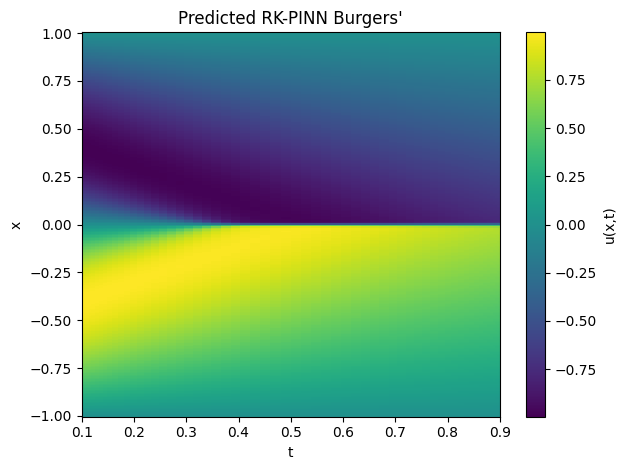

In [25]:
# Plotting the predicted output

u_pred = model.predict ( x )

t_stages = np.vstack ( ( t_start + IRK_times * (t_end - t_start), [[t_end]] ) ).flatten()
x_flat = x.flatten()

T, X = np.meshgrid ( t_stages, x_flat )
heatmap = plt.pcolormesh ( T, X, u_pred, shading = 'auto' )

plt.colorbar ( heatmap, label = "u(x,t)" )
plt.xlabel ( "t" )
plt.ylabel ( "x" )
plt.title ( "Predicted RK-PINN Burgers'" )

plt.tight_layout()
plt.show()

##### LBFGS specific, print total number of iterations actually performed.

In [29]:
if ( lbfgs_epochs ):
    print ( "Total LBFGS iterations:", lbfgs_train.num_iterations )

Total LBFGS iterations: tf.Tensor(8941, shape=(), dtype=int32)
